# Exercise 1

## Task 1

In [2]:
using Plots
#using LaTeXStrings
#using HaltonSequences
#using Primes
using Random
using Roots
using BenchmarkTools
using Distributions
using Revise
using DistributedArrays
using Distributed

LoadError: ArgumentError: Package Roots not found in current path:
- Run `import Pkg; Pkg.add("Roots")` to install the Roots package.


In [71]:
I(x′,u) = 1/(4*pi)*(x′+sin(x′/2)) - u

function transformer(u)
    f(x′) = I(x′,u)
    return find_zero(f,[0,4π])
end

function transformer_slice(u,slice)
    f(x′) = I(x′,u)
    roots = find_zero(f,slice)
    length(roots) > 1 && error("Multiple roots found!") || return roots
end

transformer (generic function with 1 method)

In [72]:
function transform_without_loop(size)
    
    return transformer.(rand(size))
    
end


transform_without_loop (generic function with 1 method)

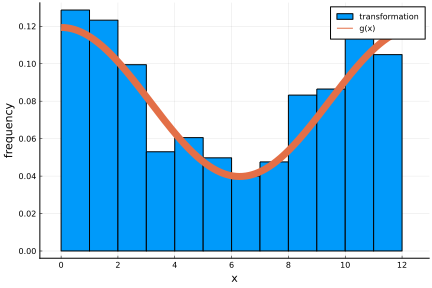

In [81]:
x_new = transform_without_loop(1000)
line = LinRange(0,4π,1000)
g(x) = 1/(4*pi)*(1+cos(x/2)/2)
    

histogram(x_new, normalize = true, label = "transformation", bins = 0:4pi)
plot!(line,g.(line), label = "g(x)", width=7, xaxis="x", yaxis="frequency",format = "svg")

## Task 2


In [91]:
#random number transformation without multi threading so basicaly the same as above but now using a foor loop such that the fuction gets comparable with the one below
function transform2(size)

    x_uniform = rand(size)
    new_x = zeros(size)

    for i in 1:size
        new_x[i] = transformer(x_uniform[i])
        
    end
    
    return new_x
    
end

transform2 (generic function with 2 methods)

In [92]:
# random number transformation with mulit threading on 4 cores
function transform(size)

    x_uniform = rand(size)
    new_x = zeros(size)

    Threads.@threads for i in 1:size
        new_x[i] = transformer(x_uniform[i])
        #id = Threads.threadid()
        #println("Hello , I am thread number $id")
    end
    return new_x
    
end

transform (generic function with 2 methods)

In [100]:
function bench(n::Int64)
    b = @benchmark transform2($n)
    b2 = @benchmark transform($n)
    min1 = minimum(b.times)
    min2 = minimum(b2.times)
    println("for $n numbers generated, the speed up is $(min1/min2)")
    return min1/min2
end 

bench (generic function with 3 methods)

In [101]:
x = bench(100)

for 100 number generated, the speed up is 2.145944335265447


2.145944335265447

for 10 number generated, the speed up is 0.9883476015763011
for 20 number generated, the speed up is 1.4154645811973963
for 30 number generated, the speed up is 1.7246402076432874
for 40 number generated, the speed up is 1.8221014053792102
for 50 number generated, the speed up is 1.915550794500982
for 60 number generated, the speed up is 2.013611148391715
for 70 number generated, the speed up is 2.0354460161802
for 80 number generated, the speed up is 2.0920808084300795
for 90 number generated, the speed up is 2.105770572097277
for 100 number generated, the speed up is 2.1067683308961773
for 1000 number generated, the speed up is 2.3614485192620682


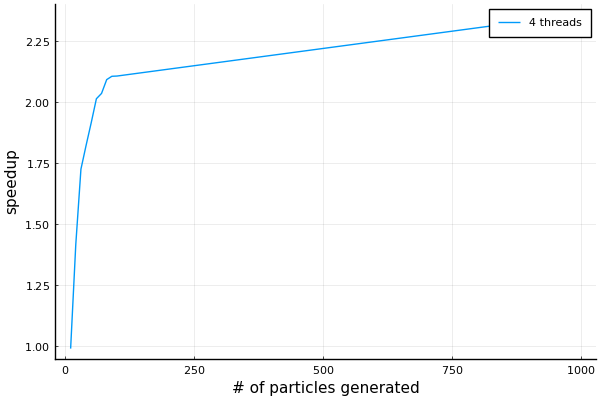

In [102]:
seq = [10,20,30,40,50,60,70,80,90,100,1000]
plot(seq,bench.(seq),label=string(Threads.nthreads()) * " threads", xaxis="# of particles generated", yaxis="speedup")


## Task 3


In [2]:
Sys.cpu_info()

4-element Vector{Base.Sys.CPUinfo}:
 Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz: 
        speed         user         nice          sys         idle          irq
     2700 MHz      54047 s          0 s      40071 s     335065 s          0 s
 Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz: 
        speed         user         nice          sys         idle          irq
     2700 MHz      17481 s          0 s      10200 s     401459 s          0 s
 Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz: 
        speed         user         nice          sys         idle          irq
     2700 MHz      50067 s          0 s      28182 s     350891 s          0 s
 Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz: 
        speed         user         nice          sys         idle          irq
     2700 MHz      15778 s          0 s       8672 s     404690 s          0 s

In [5]:
addprocs(length(Sys.cpu_info()) - nprocs())
nprocs()

4

In [5]:
workers()

3-element Vector{Int64}:
 2
 3
 4

In [7]:
enumerate(workers())

enumerate([2, 3, 4])

In [6]:
@everywhere total_particles = 1000
@everywhere slices = LinRange(0, 4pi, length(workers())+1) 

Integ(x′) = 1/(4*pi)*(x′+sin(x′/2))

#for the index of the slice n this fkt returns the number of particles in this slice
@everywhere particles_in_slice(n) = total_partiles * round(Integ(slices[i+1])-Integ(slices[i]))


@time begin
    
    # generate an array in every worker, corresponding to the respective spatial intervals
    parts = [@spawnat worker transformer_slice(particles_in_slice(i),slices[i:i+1]) for (i, worker) in enumerate(workers())]
    # combines the arrays in a DistributedArray
    S = DArray(parts)
    
end


LoadError: TaskFailedException

[91m    nested task error: [39mOn worker 2:
    KeyError: key DistributedArrays [aaf54ef3-cdf8-58ed-94cc-d582ad619b94] not found
    Stacktrace:
      [1] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90;4mdict.jl:482[0m[90m [inlined][39m
      [2] [0m[1mroot_module[22m
    [90m    @ [39m[90m./[39m[90;4mloading.jl:979[0m[90m [inlined][39m
      [3] [0m[1mdeserialize_module[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:962[0m
      [4] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:864[0m
      [5] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:782[0m
      [6] [0m[1mdeserialize_datatype[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:1287[0m
      [7] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:835[0m
      [8] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:782[0m
      [9] [0m[1mhandle_deserialize[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:842[0m
     [10] [0m[1mdeserialize[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Serialization/src/[39m[90;4mSerialization.jl:782[0m[90m [inlined][39m
     [11] [0m[1mdeserialize_msg[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mmessages.jl:87[0m
     [12] [0m[1m#invokelatest#2[22m
    [90m    @ [39m[90m./[39m[90;4messentials.jl:708[0m[90m [inlined][39m
     [13] [0m[1minvokelatest[22m
    [90m    @ [39m[90m./[39m[90;4messentials.jl:706[0m[90m [inlined][39m
     [14] [0m[1mmessage_handler_loop[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mprocess_messages.jl:169[0m
     [15] [0m[1mprocess_tcp_streams[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mprocess_messages.jl:126[0m
     [16] [0m[1m#99[22m
    [90m    @ [39m[90m./[39m[90;4mtask.jl:411[0m
    Stacktrace:
     [1] [0m[1mremotecall_fetch[22m[0m[1m([22m::[0mFunction, ::[0mDistributed.Worker, ::[0mFuture, ::[0mVararg[90m{Any, N} where N[39m; [90mkwargs[39m::[0mBase.Iterators.Pairs[90m{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
    [90m   @ [39m[35mDistributed[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mremotecall.jl:394[0m
     [2] [0m[1mremotecall_fetch[22m[0m[1m([22m::[0mFunction, ::[0mDistributed.Worker, ::[0mFuture, ::[0mVararg[90m{Any, N} where N[39m[0m[1m)[22m
    [90m   @ [39m[35mDistributed[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mremotecall.jl:386[0m
     [3] [0m[1m#remotecall_fetch#146[22m
    [90m   @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mremotecall.jl:421[0m[90m [inlined][39m
     [4] [0m[1mremotecall_fetch[22m
    [90m   @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Distributed/src/[39m[90;4mremotecall.jl:421[0m[90m [inlined][39m
     [5] [0m[1m(::DistributedArrays.var"#22#28"{Vector{Future}, Vector{Tuple}, Vector{Int64}, Tuple{Int64, Int64}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[36mDistributedArrays[39m [90m./[39m[90;4mtask.jl:411[0m

...and 2 more exceptions.
